# Image Colorization - Vision and Cognitive Services
Authors: *Jacopo Guidolin, Giovanni Vedana*

In [1]:
import numpy as np 
import pandas as pd

import tensorflow as tf
from tensorflow.keras.layers import Conv2D,InputLayer, Conv2DTranspose, Dropout, BatchNormalization, Input, Concatenate, Activation, concatenate ,RepeatVector ,Reshape ,UpSampling2D
from keras.initializers import RandomNormal
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.optimizers import Adam
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model

from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
import cv2
import PIL
from skimage import transform
from PIL import Image
import random
import h5py
import os

import matplotlib.pyplot as plt
import keras

In [ ]:
## TRAIN SET

# LOAD GRAYSCALE IMAGES
  images_gray = np.load('imagesL_IN2.npz')[:-100]
  images_gray = images_gray.astype('float')
  X_train = images_gray.reshape((len(gray_scale), 224, 224, 1))

# LOAD AB VALUES 
  Y = np.load('imagesAB_IN2.npz')[:-100].astype('float')

In [ ]:
## TEST SET

# LOAD GRAYSCALE IMAGES
  images_gray = np.load('imagesL_IN2.npz')[-100:]
  images_gray = images_gray.astype('float')
  X_test = images_gray.reshape((100, 224, 224, 1))

# LOAD AB VALUES 
  Y_test = np.load('imagesAB_IN2.npz')[-100:].astype('float')

# Converting LAB to RGB 

In [ ]:
def get_LAB(image_l, image_ab  ):
       
    image_l = image_l.reshape((224, 224, 1))
    image_lab = np.concatenate((image_l, image_ab), axis=2)
    image_lab *= 255.0
    image_lab = image_lab.astype("uint8")
 
    image_rgb = cv2.cvtColor(image_lab, cv2.COLOR_LAB2RGB)
    image_rgb = Image.fromarray(image_rgb)
    return image_rgb
def get_LAB1(image_l  ):
    image_ab =  np.ones((224,224,2))*128
    image_l = image_l.reshape((224, 224, 1))
    image_lab = np.concatenate((image_l, image_ab), axis=2)
    
    image_lab *= 255.0
    image_lab = image_lab.astype("uint8")
 
    image_rgb = cv2.cvtColor(image_lab, cv2.COLOR_LAB2RGB)
    image_rgb = Image.fromarray(image_rgb)
    return image_rgb

# Simple CNN

In [2]:
model = Sequential()
model.add(Conv2D(8, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', strides=2))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))


Input_Sample = Input(shape=(224, 224,1))
Output_ = model(Input_Sample)
model = Model(inputs=Input_Sample, outputs=Output_)


model.compile(optimizer=Adam(lr=1e-3), loss=tf.compat.v1.losses.mean_pairwise_squared_error)


model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 1)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 2)       31618     
Total params: 31,618
Trainable params: 31,618
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
model.fit(X_train, Y, batch_size=10, epochs=20)

In [ ]:
output = model.predict(image_l)

Text(0.5, 1.0, 'Original')

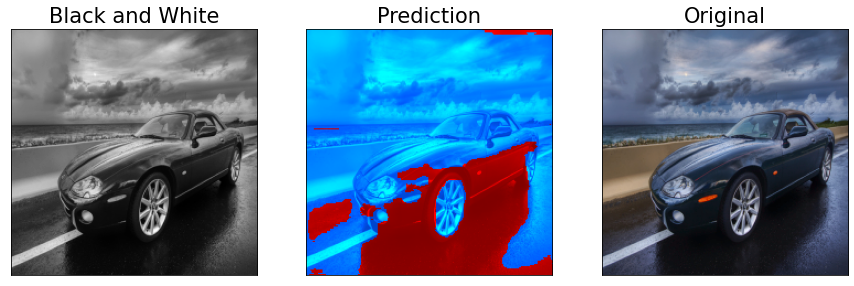

In [ ]:
  plt.figure(figsize = (15, 10))
  plt.subplot(131)
  plt.imshow(image, cmap = 'gray')
  plt.xticks([])
  plt.yticks([])
  plt.title('Black and White', fontsize = 21)
  plt.subplot(132)
  plt.imshow((get_LAB(image_l,output)))
  plt.xticks([])
  plt.yticks([])  
  plt.title('Prediction', fontsize = 21)
  plt.subplot(133)
  plt.imshow(get_LAB(image_l, image_ab))
  plt.xticks([])
  plt.yticks([]) 
  plt.title('Original', fontsize = 21)

# Feature Extraction through the Inception

# Loading the pretrained Model 

In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, decode_predictions, preprocess_input
inception = InceptionResNetV2(weights=None, include_top=True)
inception.load_weights('/content/gdrive/MyDrive/inception_resnet_v2_weights_tf_dim_ordering_tf_kernels.h5')
inception.graph = tf.get_default_graph()

Instructions for updating:
non-resource variables are not supported in the long term
Instructions for updating:
Colocations handled automatically by placer.


In [ ]:
#To generate embeddings by passing input images through InceptionResNetV2
def create_inception_embedding(grayscaled_rgb):
    grayscaled_rgb_resized = []
    for i in grayscaled_rgb:
        i = resize(i, (299, 299, 3), mode='constant')
        grayscaled_rgb_resized.append(i)
    grayscaled_rgb_resized = np.array(grayscaled_rgb_resized)
    grayscaled_rgb_resized = preprocess_input(grayscaled_rgb_resized)
    with inception.graph.as_default():
        embed = inception.predict(grayscaled_rgb_resized)
    return embed
import tensorflow as tf

In [ ]:
#creating embeddings for Train data
incept_em = create_inception_embedding(X_train)
embeddings = RepeatVector(28 * 28)(incept_em)
layer_embedding_train = Reshape(([28, 28, 1000]))(embeddings)

> > # THE MODEL

In [ ]:
#Encoder
embed_input = Input(shape=(28, 28, 1000))
encoder_input = Input(shape=(224, 224, 1,))
encoder_1 = Conv2D(64, (3,3), activation='relu', padding='same', strides=2)(encoder_input)
encoder_2 = Conv2D(128, (3,3), activation='relu', padding='same')(encoder_1)
encoder_3 = Conv2D(128, (3,3), activation='relu', padding='same', strides=2)(encoder_2)
encoder_4 = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_3)
encoder_5 = Conv2D(256, (3,3), activation='relu', padding='same', strides=2)(encoder_4)
encoder_6 = Conv2D(512, (3,3), activation='relu', padding='same')(encoder_5)
encoder_7 = Conv2D(512, (3,3), activation='relu', padding='same')(encoder_6)
encoder_output= Conv2D(256, (3,3), activation='relu', padding='same')(encoder_7)
#Fusion layer
fusion_output = concatenate([encoder_output, embed_input], axis=3) 
fusion_output = Conv2D(256, (1, 1), activation='relu', padding='same')(fusion_output)
fusion_output = Conv2D(256, (1, 1), activation='relu', padding='same')(fusion_output)
#Decoder layer
decoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(fusion_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(64, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(32, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = Conv2D(16, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = Conv2D(2, (3, 3), activation='relu', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
model = Model(inputs=[encoder_input,embed_input], outputs=decoder_output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
conv2d_203 (Conv2D)             (None, 112, 112, 64) 640         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_204 (Conv2D)             (None, 112, 112, 128 73856       conv2d_203[0][0]                 
__________________________________________________________________________________________________
conv2d_205 (Conv2D)             (None, 56, 56, 128)  147584      conv2d_204[0][0]                 
______________________________________________________________________________________________

# Training

In [ ]:
model.compile(optimizer='adam', loss='mse',metrics=['accuracy'])

In [ ]:
model.fit(x=[X_train,layer_embedding_train] ,y=Y,batch_size=30, epochs=100,steps_per_epoch=1)

# Load the weights

In [ ]:
model = keras.models.load_model('/content/gdrive/MyDrive/model')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


# The prediction

In [ ]:
# creating embeddings for test data
incept_em = create_inception_embedding(X_test)
embeddings = RepeatVector(28 * 28)(incept_em)
layer_embedding_test = Reshape(([28, 28, 1000]))(embeddings)

In [ ]:
output = model.predict([X_test,layer_embedding_test],steps=3)

# Resulting Images 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


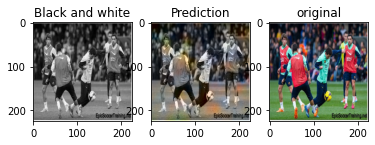

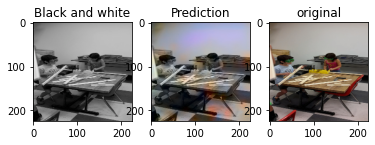

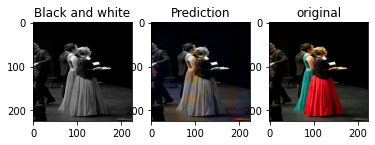

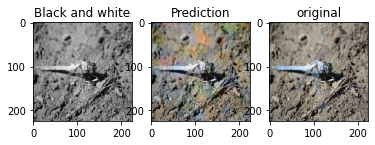

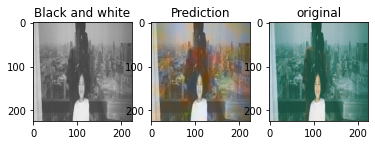

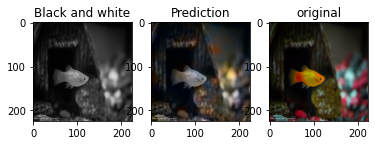

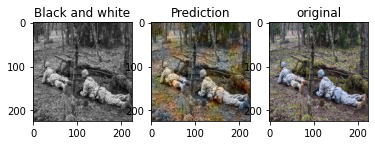

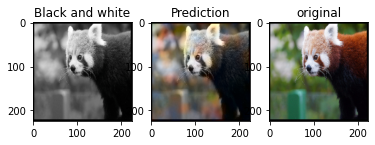

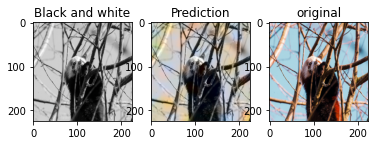

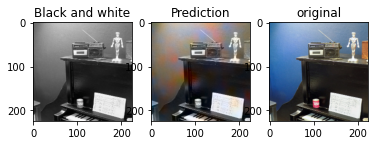

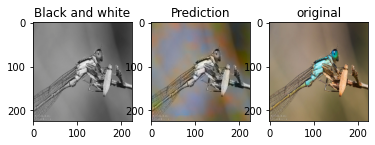

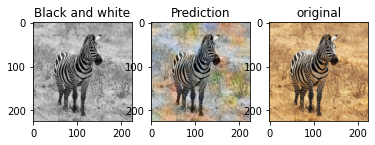

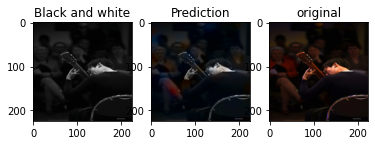

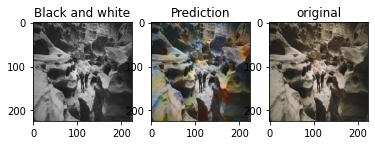

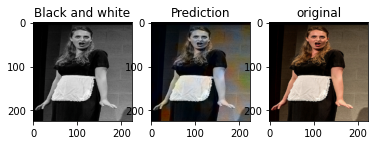

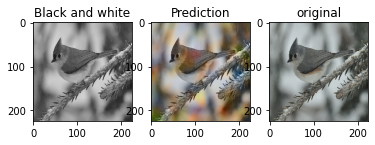

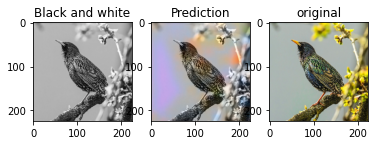

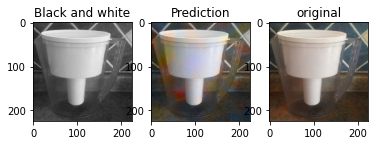

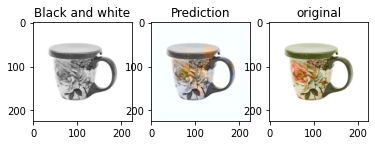

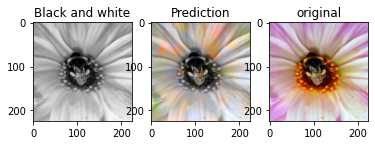

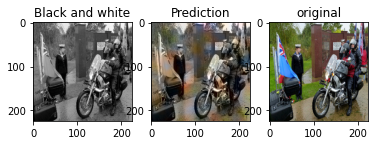

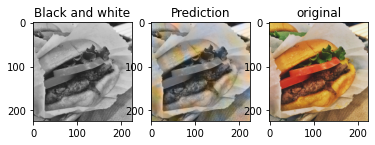

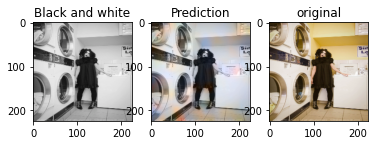

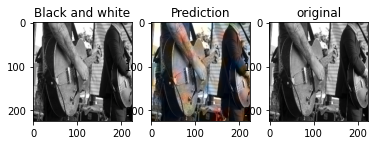

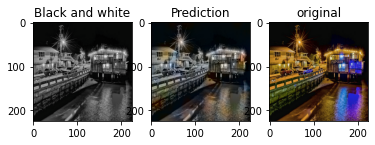

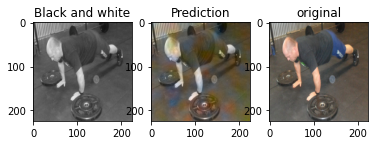

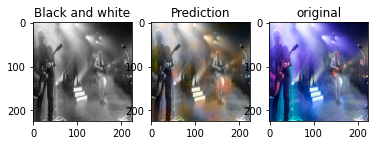

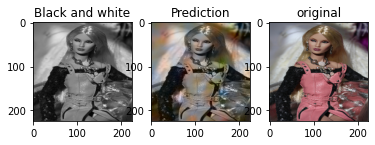

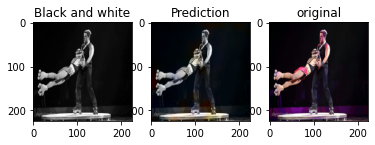

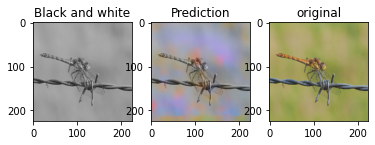

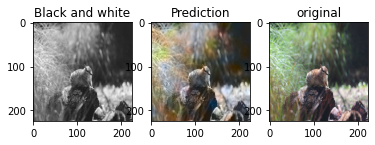

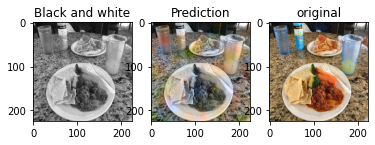

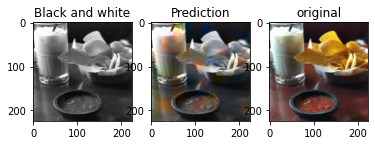

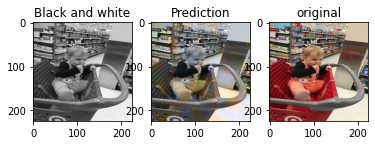

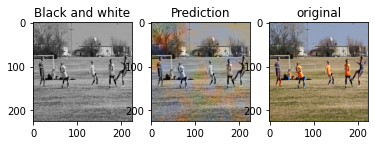

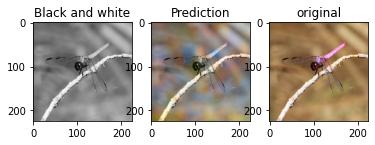

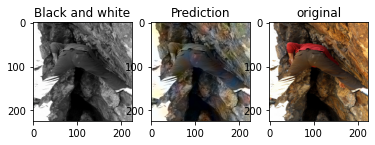

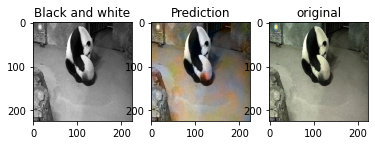

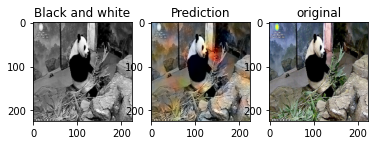

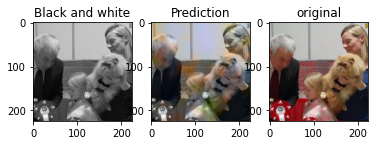

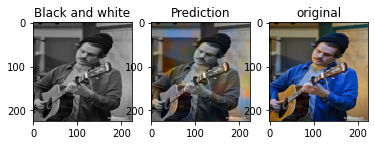

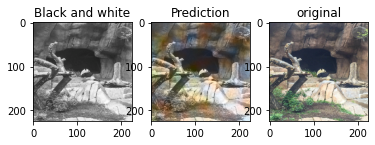

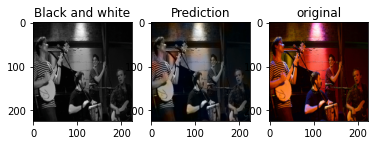

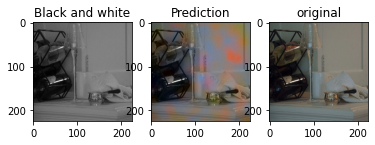

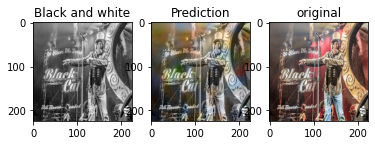

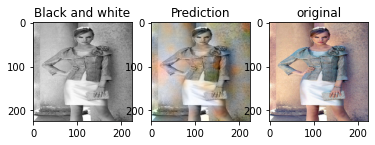

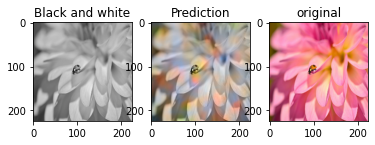

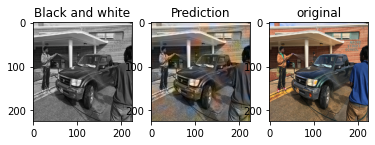

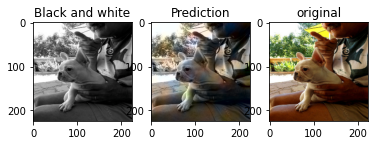

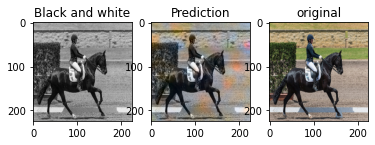

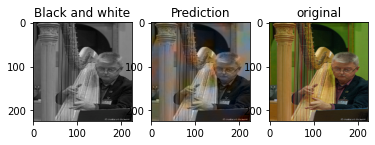

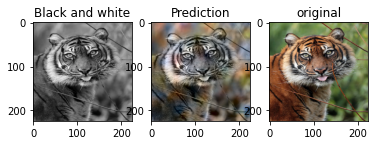

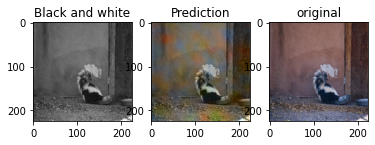

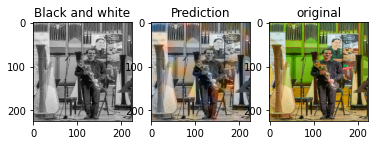

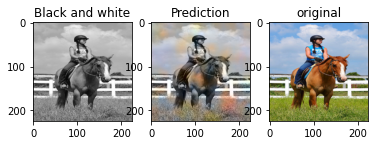

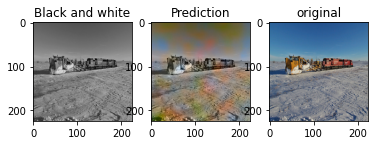

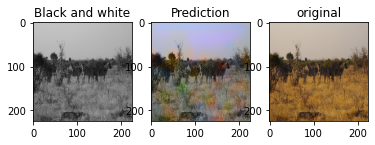

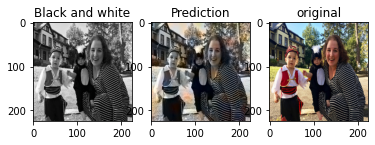

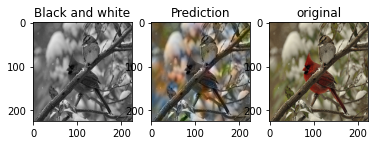

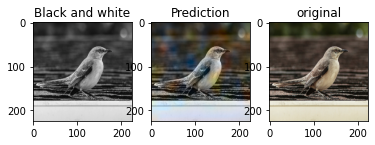

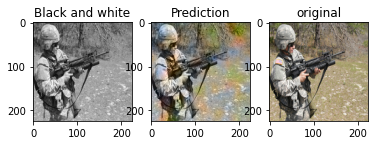

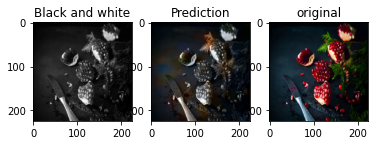

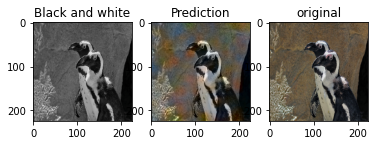

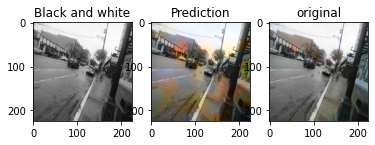

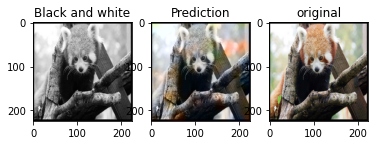

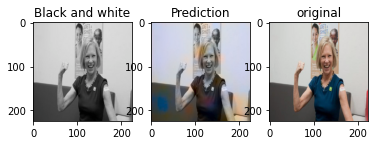

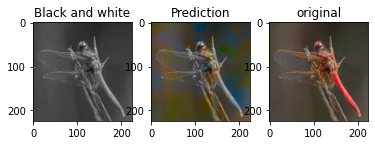

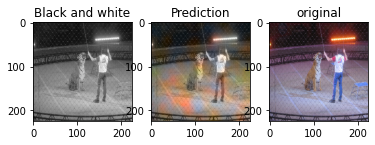

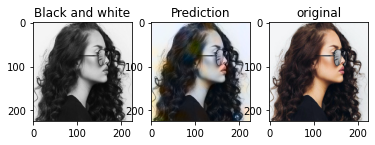

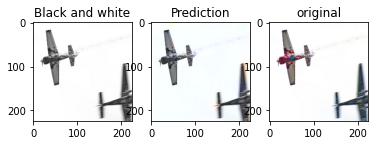

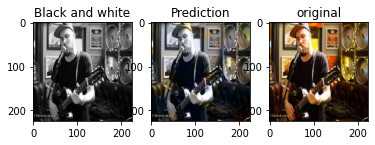

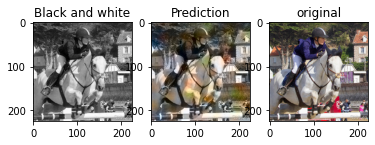

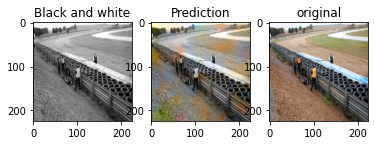

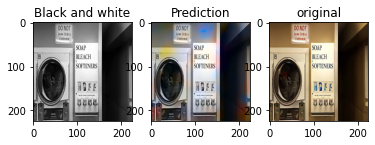

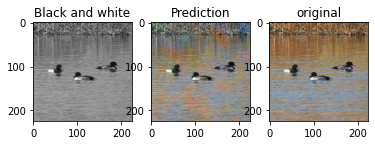

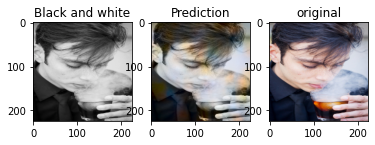

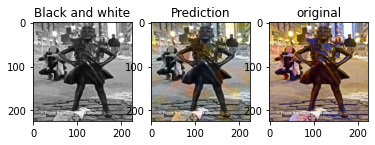

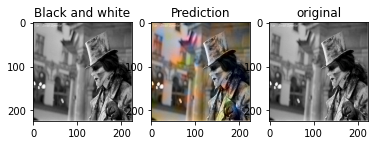

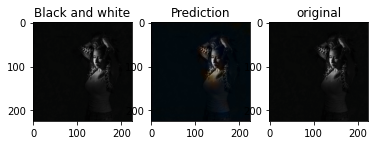

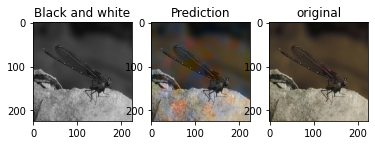

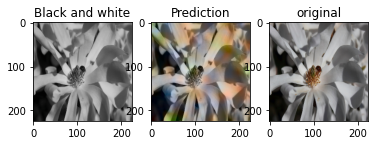

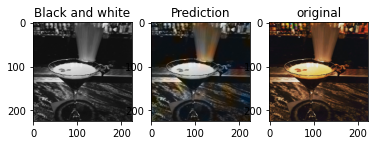

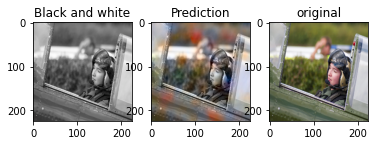

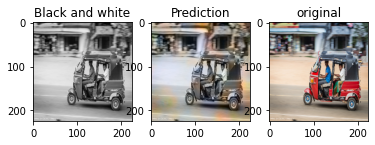

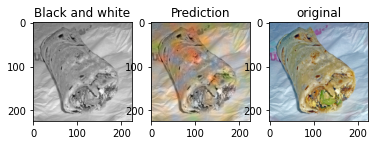

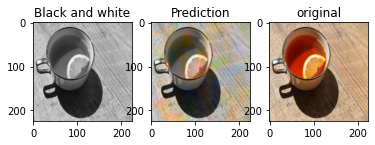

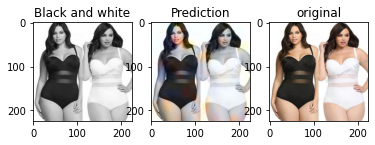

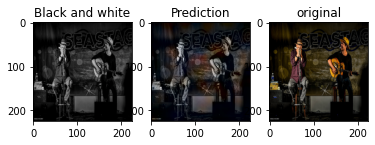

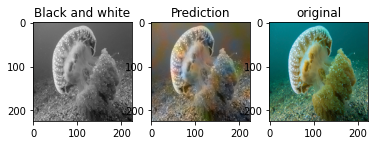

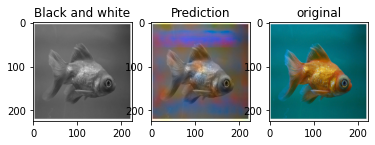

In [ ]:
for i in range(0,90):
    pred = get_LAB(X_test[i],output[i])
    real = get_LAB(X_test[i],Y_test[i])
    original = get_LAB1(X_test[i])
    f, axarr = plt.subplots(1,3)
    axarr[0].title.set_text('Black and white')  
    axarr[1].title.set_text('Prediction')  
    axarr[2].title.set_text('original')  
    axarr[0].imshow(original)
    axarr[1].imshow(pred)
    axarr[2].imshow(real)
    
    
    